In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys, math
import gc
import pandas as pd
import numpy as np
from time import perf_counter
from tqdm.notebook import tqdm
notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent / "src"))
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessor.preprocessing import IMDBPreprocessor
from models.naive_bayes import NaiveBayes
from models.knn import KNN
from vectorizer.bag_of_words import BoWVectorizer  
from vectorizer.tfidf import TfidfVectorizerScratch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

project_root = notebook_dir.parent

In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 6)

HTML("""
<style>
.container { width:100% !important; }
.output_png { display: block; margin-left: auto; margin-right: auto; }
</style>
""")

In [3]:
df = pd.read_parquet(project_root / "data" / "imdb_reviews.parquet")
df = df[["review", "sentiment"]].dropna().reset_index(drop=True)

In [4]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["review"].astype(str), df["sentiment"].astype(int), test_size=0.2, random_state=42, stratify=df["sentiment"]
)

In [5]:
X_train_tok = X_train_text.str.split().tolist()
X_test_tok  = X_test_text.str.split().tolist()

## BOW + naive bayes

In [6]:
vectorizers = {
    "bow": lambda: BoWVectorizer(binary=False, min_df=2),
    "bow_binary": lambda: BoWVectorizer(binary=True, min_df=2),
    "tfidf": lambda: TfidfVectorizerScratch(min_df=2, sublinear_tf=False, l2_norm=False),
    "tfidf_norm": lambda: TfidfVectorizerScratch(min_df=2, sublinear_tf=True, l2_norm=True),
}

models = {
    "naive_bayes": lambda: NaiveBayes(alpha=1.0),
    "knn": lambda: KNN(k=7, distance_metric="cosine"),
}

In [7]:
results = []  # store only y_true & y_pred for each combination

v_items = list(vectorizers.items())
m_items = list(models.items())

for v_name, v_ctor in tqdm(v_items, desc="Vectorizers", total=len(v_items)):
    vec = v_ctor()
    X_tr = vec.fit_transform(X_train_tok)
    X_te = vec.transform(X_test_tok)

    for m_name, m_ctor in tqdm(m_items, desc=f"Models ({v_name})", total=len(m_items), leave=False):
        model = m_ctor()
        model.fit(X_tr, y_train.tolist())
        y_pred = model.predict(X_te)

        results.append({
            "vectorizer": v_name,
            "model": m_name,
            "y_true": y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.asarray(y_test),
            "y_pred": np.asarray(y_pred),
        })

        del model, y_pred
        gc.collect()

    del X_tr, X_te, vec
    gc.collect()


Vectorizers:   0%|          | 0/4 [00:00<?, ?it/s]

Models (bow):   0%|          | 0/2 [00:00<?, ?it/s]

Models (bow_binary):   0%|          | 0/2 [00:00<?, ?it/s]

Models (tfidf):   0%|          | 0/2 [00:00<?, ?it/s]

Models (tfidf_norm):   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
summary = []
for r in results:
    acc = accuracy_score(r["y_true"], r["y_pred"])
    f1  = f1_score(r["y_true"], r["y_pred"])
    summary.append({"vectorizer": r["vectorizer"], "model": r["model"], "accuracy": acc, "f1": f1})

results_df = pd.DataFrame(summary).sort_values(["accuracy", "f1"], ascending=False).reset_index(drop=True)
results_df

,vectorizer,model,accuracy,f1
0,tfidf_norm,naive_bayes,0.868004,0.867066
1,bow_binary,naive_bayes,0.861853,0.859890
2,bow,naive_bayes,0.858425,0.856177
3,tfidf,naive_bayes,0.849450,0.846288
4,tfidf_norm,knn,0.820510,0.830637
5,bow_binary,knn,0.809116,0.813000
6,tfidf,knn,0.789957,0.803026
7,bow,knn,0.757285,0.763904


In [9]:
best_row = results_df.iloc[0]
best_vec_name = best_row["vectorizer"]
best_model_name = best_row["model"]
print(f"Best combo: {best_vec_name} + {best_model_name} | acc={best_row['accuracy']:.4f} f1={best_row['f1']:.4f}")

Best combo: tfidf_norm + naive_bayes | acc=0.8680 f1=0.8671


In [10]:
for r in results:
    print("="*60)
    print(f"Vectorizer: {r['vectorizer']} | Model: {r['model']}")
    print(classification_report(r["y_true"], r["y_pred"], target_names=["neg","pos"]))

Vectorizer: bow | Model: naive_bayes
              precision    recall  f1-score   support

         neg       0.84      0.88      0.86      4940
         pos       0.87      0.84      0.86      4977

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

Vectorizer: bow | Model: knn
              precision    recall  f1-score   support

         neg       0.77      0.73      0.75      4940
         pos       0.75      0.78      0.76      4977

    accuracy                           0.76      9917
   macro avg       0.76      0.76      0.76      9917
weighted avg       0.76      0.76      0.76      9917

Vectorizer: bow_binary | Model: naive_bayes
              precision    recall  f1-score   support

         neg       0.85      0.88      0.86      4940
         pos       0.88      0.84      0.86      4977

    accuracy                           0.86      9917
   macro avg      

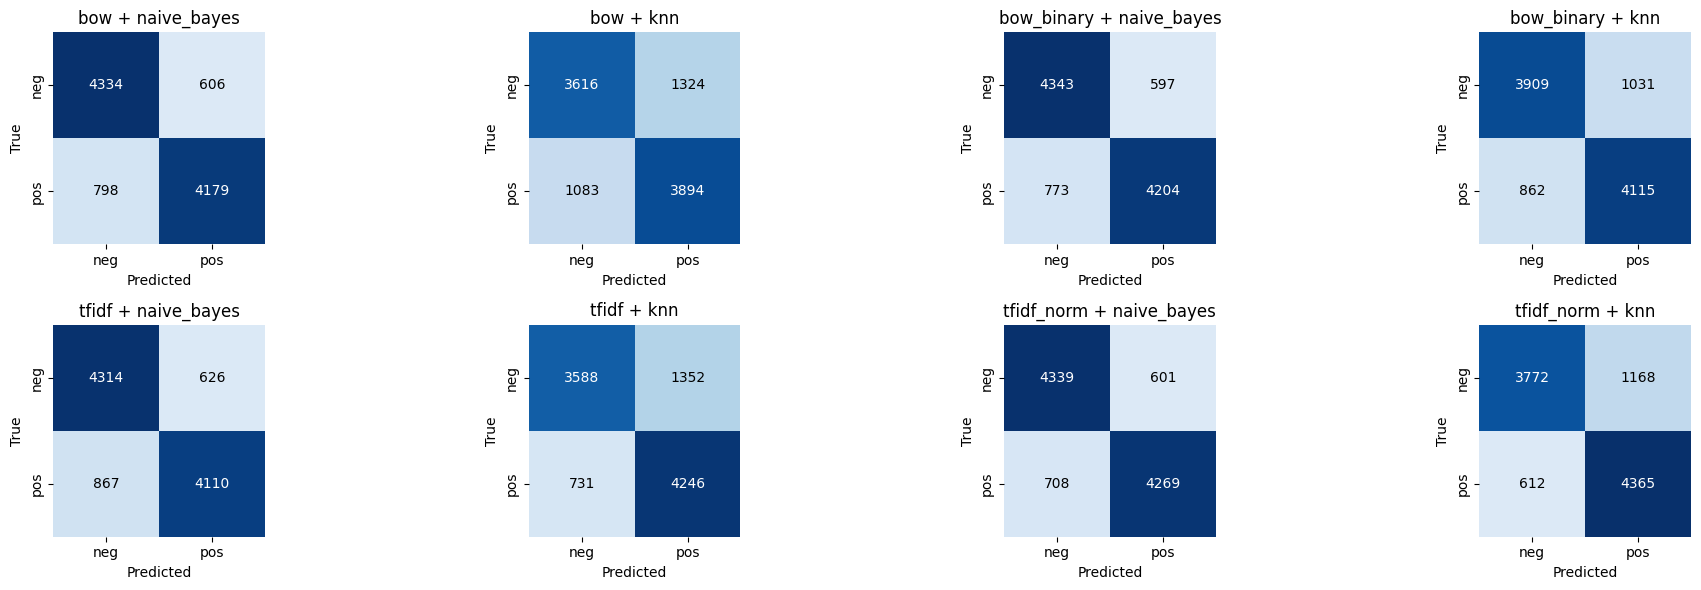

In [11]:
def plot_cm_grid(results, n_rows=2, n_cols=4, cmap="Blues"):
    total = len(results)
    per_fig = n_rows * n_cols
    num_figs = math.ceil(total / per_fig)

    # global max for consistent color scaling
    global_max = max(
        confusion_matrix(r["y_true"], r["y_pred"], labels=[0, 1]).max()
        for r in results
    )

    for f in range(num_figs):
        sub = results[f*per_fig : (f+1)*per_fig]
        fig, axes = plt.subplots(n_rows, n_cols)
        axes = np.atleast_1d(axes).ravel()

        for ax, r in zip(axes, sub):
            cm = confusion_matrix(r["y_true"], r["y_pred"], labels=[0, 1])
            hm = sns.heatmap(
                cm, annot=False, cmap=cmap, cbar=False, square=True,
                xticklabels=["neg","pos"], yticklabels=["neg","pos"], ax=ax,
                vmin=0, vmax=global_max  # global intensity
            )
            ax.set_title(f"{r['vectorizer']} + {r['model']}")
            ax.set_xlabel("Predicted"); ax.set_ylabel("True")

            # contrast-aware annotations
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    val = cm[i, j]
                    frac = val / global_max if global_max else 0.0
                    color = "white" if frac > 0.5 else "black"
                    ax.text(j + 0.5, i + 0.5, f"{val}",
                            ha="center", va="center",
                            color=color, fontsize=10)

        # turn off unused axes
        for ax in axes[len(sub):]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

plot_cm_grid(results, n_rows=2, n_cols=4)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm import LinearSVC

In [13]:
sk_vecs = {
    "sk_count_unigram":  CountVectorizer(min_df=5, max_features=50000, ngram_range=(1,1)),
    "sk_count_uni_bi":   CountVectorizer(min_df=5, max_features=60000, ngram_range=(1,2)),
    "sk_tfidf_unigram":  TfidfVectorizer(min_df=5, max_features=50000, ngram_range=(1,1), sublinear_tf=True),
    "sk_tfidf_uni_bi":   TfidfVectorizer(min_df=5, max_features=60000, ngram_range=(1,2), sublinear_tf=True),
}

In [14]:
sk_models = {
    "logreg_l2":  LogisticRegression(max_iter=200, C=1.0, n_jobs=-1, random_state=42),
    "linear_svc": LinearSVC(C=1.0, random_state=42),
    "sgd_log":    SGDClassifier(loss="log_loss", alpha=1e-4, random_state=42),
    "sgd_hinge":  SGDClassifier(loss="hinge", alpha=1e-4, random_state=42),
    "mnb":        MultinomialNB(alpha=1.0),
    "cnb":        ComplementNB(alpha=1.0),
    "bnb":        BernoulliNB(alpha=1.0),
}

In [15]:
sk_results = []

for v_name, vec in tqdm(sk_vecs.items(), desc="SK Vectorizers"):
    X_tr = vec.fit_transform(X_train_text)
    X_te = vec.transform(X_test_text)

    for m_name, model in tqdm(sk_models.items(), desc=f"Models @ {v_name}", leave=False):
        model.fit(X_tr, y_train.to_numpy())
        y_pred = model.predict(X_te)

        sk_results.append({
            "vectorizer": v_name,
            "model": m_name,
            "y_true": y_test,
            "y_pred": y_pred,
        })

        del model, y_pred
        gc.collect()

    del X_tr, X_te, vec
    gc.collect()

# summary table
sk_summary = []
for r in sk_results:
    sk_summary.append({
        "vectorizer": r["vectorizer"],
        "model": r["model"],
        "accuracy": accuracy_score(r["y_true"], r["y_pred"]),
        "f1": f1_score(r["y_true"], r["y_pred"]),
    })
sk_results_df = pd.DataFrame(sk_summary).sort_values(["accuracy","f1"], ascending=False).reset_index(drop=True)
sk_results_df.head(10)

SK Vectorizers:   0%|          | 0/4 [00:00<?, ?it/s]

Models @ sk_count_unigram:   0%|          | 0/7 [00:00<?, ?it/s]

Models @ sk_count_uni_bi:   0%|          | 0/7 [00:00<?, ?it/s]

Models @ sk_tfidf_unigram:   0%|          | 0/7 [00:00<?, ?it/s]

Models @ sk_tfidf_uni_bi:   0%|          | 0/7 [00:00<?, ?it/s]

,vectorizer,model,accuracy,f1
0,sk_tfidf_uni_bi,linear_svc,0.905112,0.905815
1,sk_tfidf_uni_bi,sgd_hinge,0.902188,0.904131
2,sk_tfidf_uni_bi,logreg_l2,0.901381,0.902899
3,sk_tfidf_unigram,logreg_l2,0.897348,0.898767
4,sk_tfidf_unigram,sgd_hinge,0.896642,0.898725
5,sk_count_uni_bi,sgd_log,0.895835,0.895646
6,sk_count_uni_bi,logreg_l2,0.895331,0.895825
7,sk_tfidf_unigram,linear_svc,0.893012,0.893783
8,sk_tfidf_uni_bi,sgd_log,0.888676,0.890888
9,sk_tfidf_unigram,sgd_log,0.887768,0.890052


In [16]:
combined_df = (
    pd.concat([results_df.assign(source="scratch"),
               sk_results_df.assign(source="sklearn")], ignore_index=True)
    .sort_values(["accuracy","f1"], ascending=False)
    .reset_index(drop=True)
)
combined_df.head(15)

,vectorizer,model,accuracy,f1,source
0,sk_tfidf_uni_bi,linear_svc,0.905112,0.905815,sklearn
1,sk_tfidf_uni_bi,sgd_hinge,0.902188,0.904131,sklearn
2,sk_tfidf_uni_bi,logreg_l2,0.901381,0.902899,sklearn
3,sk_tfidf_unigram,logreg_l2,0.897348,0.898767,sklearn
4,sk_tfidf_unigram,sgd_hinge,0.896642,0.898725,sklearn
5,sk_count_uni_bi,sgd_log,0.895835,0.895646,sklearn
6,sk_count_uni_bi,logreg_l2,0.895331,0.895825,sklearn
7,sk_tfidf_unigram,linear_svc,0.893012,0.893783,sklearn
8,sk_tfidf_uni_bi,sgd_log,0.888676,0.890888,sklearn
9,sk_tfidf_unigram,sgd_log,0.887768,0.890052,sklearn


In [17]:
def plot_cm_grid_ranked(
    results,
    n_rows: int = 2,
    n_cols: int = 4,
    top_n: int | None = None,
    labels: tuple = (0, 1),
    figsize_scale: float = 3.2,
):
    if not results:
        print("No results to plot.")
        return

    scored = [(accuracy_score(r["y_true"], r["y_pred"]), r) for r in results]
    scored.sort(key=lambda x: x[0], reverse=True)
    if top_n is not None:
        scored = scored[:top_n]
    ordered = [r for _, r in scored]

    total = len(ordered)
    per_fig = n_rows * n_cols
    num_figs = math.ceil(total / per_fig)

    for f in range(num_figs):
        sub = ordered[f * per_fig : (f + 1) * per_fig]
        fig, axes = plt.subplots(n_rows, n_cols)
        axes = np.atleast_1d(axes).ravel()

        for ax, r in zip(axes, sub):
            y_true, y_pred = r["y_true"], r["y_pred"]
            cm = confusion_matrix(y_true, y_pred, labels=list(labels)).astype(float)
            row_sums = cm.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1.0
            cm_pct = cm / row_sums   # rows sum to 1

            signed = cm_pct.copy()
            for i in range(len(labels)):
                for j in range(len(labels)):
                    if i != j:
                        signed[i, j] *= -1  # off-diagonals negative

            sns.heatmap(
                signed,
                ax=ax,
                cmap="RdYlGn",
                vmin=-1, vmax=1, center=0,
                cbar=False,
                square=True,
                linewidths=0.5, linecolor="white",
                xticklabels=[str(l) for l in labels],
                yticklabels=[str(l) for l in labels],
                annot=False,
            )

            for i in range(len(labels)):
                for j in range(len(labels)):
                    cnt = int(cm[i, j])
                    pct = 100.0 * cm_pct[i, j]
                    intensity = abs(signed[i, j])
                    color = "white" if intensity > 0.5 else "black"
                    ax.text(j + 0.5, i + 0.44, f"{cnt}", ha="center", va="center",
                            fontsize=10, color=color)
                    ax.text(j + 0.5, i + 0.76, f"({pct:.1f}%)", ha="center", va="center",
                            fontsize=8, color=color)

            acc = accuracy_score(y_true, y_pred)
            ax.set_title(f"{r.get('vectorizer','?')} + {r.get('model','?')}\nacc={acc:.3f}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")

        for ax in axes[len(sub):]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

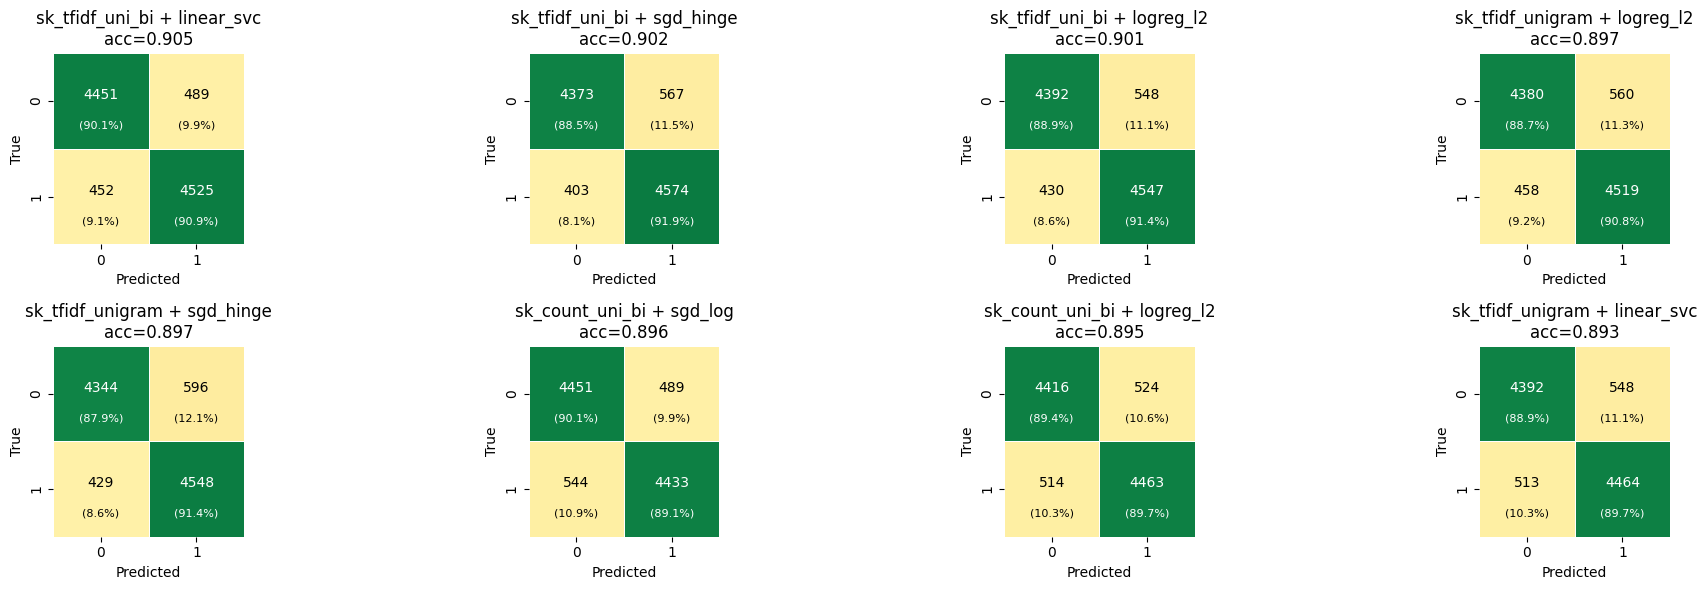

In [18]:
topN = 8
top_rows = combined_df.head(topN)

# build results-like list for the plotting util
cm_inputs = []
for _, row in top_rows.iterrows():
    # find the corresponding preds container
    bucket = sk_results if row["source"]=="sklearn" else results
    hit = next(r for r in bucket if r["vectorizer"]==row["vectorizer"] and r["model"]==row["model"])
    cm_inputs.append(hit)

plot_cm_grid_ranked(cm_inputs, n_rows=2, n_cols=4, top_n=None)  # uses the nicer normalized diverging view

In [19]:
best_sk = sk_results_df.iloc[0]
vec = sk_vecs[best_sk["vectorizer"]]
X_tr = vec.fit_transform(X_train_text)
X_te = vec.transform(X_test_text)

mdl = sk_models[best_sk["model"]]
mdl.fit(X_tr, y_train.to_numpy())

feat_names = np.array(vec.get_feature_names_out())

def show_top_linear(model, n=20):
    if hasattr(model, "coef_"):
        w = model.coef_.ravel()
    elif hasattr(model, "feature_log_prob_"):  # NB diff
        w = model.feature_log_prob_[1] - model.feature_log_prob_[0]
    else:
        print("No linear weights available.")
        return
    top_pos = np.argsort(w)[-n:][::-1]
    top_neg = np.argsort(w)[:n]
    print("Top positive:", ", ".join(feat_names[top_pos]))
    print("Top negative:", ", ".join(feat_names[top_neg]))

show_top_linear(mdl, n=20)

Top positive: ratingpos, excellent, great, perfect, amazing, well worth, must see, best, hilarious, wonderful, subtle, refreshing, one best, enjoyable, favorite, gem, brilliant, superb, loved, today
Top negative: worst, ratingneg, awful, bad, waste, boring, terrible, ratingneutral, fails, forgettable, poor, horrible, disappointment, disappointing, dull, poorly, nothing, worse, annoying, mediocre
